# 3D Cervical Vertebrae Segmentation (RSNA 2022) with MONAI
---

The aim of this notebook is to perform **3D semantic segmentation** on CT scan provided by Radiological Society of North America (RSNA) during the past kaggle's competition RSNA 2022 targeting cervical vertebrae.

# Set-Up
---

In this section we will install all the necessary packages and we will import the necessary libraries

In [1]:
! pip install python-gdcm
! pip install pylibjpeg pylibjpeg-libjpeg pydicom
! pip install pyjpegls
! pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.8 MB/s eta 0:00:00


In [2]:
# Importing libraries
import os
import random
import string
import time
import csv
from tqdm import tqdm
from glob import glob
import csv
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.ndimage as ndi
import seaborn as sns
sns.set_theme(style="whitegrid")

# To read dicom file
import pydicom
from pydicom import dcmread

# To read nifti file
import nibabel as nib

# Required dependencies
import gdcm
import pylibjpeg

# Monai
from monai.data import ArrayDataset, DataLoader, decollate_batch
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Compose,
    Activations,
    AsDiscrete,
    Resize,
    Zoom,
    ScaleIntensity,
    RandFlip,
    RandGridDistortion,
    RandAffine
)
from monai.utils import set_determinism, first

# Sklearn
from sklearn.model_selection import KFold

# PyTorch
import torch
import torch.nn as nn
from torch.nn.functional import one_hot

/opt/conda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


# Notebook ID
---

In [3]:
def generate_id():
    """ Function to generate notebook ID"""
    letters = string.ascii_uppercase  # Uppercase letters A-Z
    digits = string.digits  # Digits 0-9
    start_letters = ''.join(random.choice(letters) for _ in range(2))
    middle_digits = ''.join(random.choice(digits) for _ in range(4))
    end_letters = ''.join(random.choice(letters) for _ in range(2))
    id_number = start_letters + middle_digits + end_letters
    return id_number

ID = generate_id()
print(ID)

MM1329ZP


# Set Deterministic Training for Reproducibility
---

In [4]:
set_determinism(seed=0)

# Configuration
---

In this section we will define **constants** and **variables**.

In [5]:
# Path 
TRAIN_IMAGES_PATH = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images'
SEGMENTATIONS_PATH = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/segmentations'
OUTPUT_DIR = '.'
OUTPUT_FILE = OUTPUT_DIR + f'/{ID}_train_val_losses.csv'
CONFIG_FILE = OUTPUT_DIR + f'/{ID}_config.pkl'

# Dictionary to store configuration of training and model architecture
config = {
     'ID' : ID,
    # Data Preprocessing params
    'spatial_size' : (128, 128, 128),         # Target spatial size of the volume (CT scan & segmentation masks)
    'prob' : 0.5,                             # Probability of applying the augmentation technique
     'k' : 5,                                 # Number of folders for K-fold
    # Training Params
    'batch_size' : 4, 
    'epochs' : 80,                            
    'lr' : 1e-4,                              # learning rate optimization algorithm
    'loss_weights' : (0.05, 0.95),        # weights in bce_dice loss (bce_weight, dice_weight)
    # Model Architecture Params
    'channels' : (16, 32, 64, 128, 256),      # Channels per layer
    'strides' : (2, 2, 2, 2),                 # Stride per layers
    'kernel_size' : 3,                        # Size of the kernel for each layer
    'up_kernel_size' : 3,
    'num_res_units' : 2,                      # Number of residual units
    'act' : 'PRELU',                          # Activation function
    'dropout' : 0.0,                          # Dropout rate
    'bias' : True,
    # K-Fold
    'val_fold_idx' : 1                        # Validation index
}

In [6]:
# Save config to pickle file
with open(CONFIG_FILE, 'wb') as f:
    pickle.dump(config, f)

In [7]:
# Masks to be reverted along the z-axis
revert_mask = [
    '1.2.826.0.1.3680043.1363',
    '1.2.826.0.1.3680043.20120',
    '1.2.826.0.1.3680043.2243',
    '1.2.826.0.1.3680043.24606',
    '1.2.826.0.1.3680043.32071'
    ]

# Setting Up PyTorch for GPU Acceleration
---

In [8]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Enable cuDNN benchmark. Set to True whenever the input model does not change over training, False if, eg, some layers are deactivated
torch.backends.cudnn.benchmark = True

GPU: Tesla T4 is available.
cuda


# Function Declaration
---

In [9]:
def read_dicom_scan(folder_path):
    """ Read CT scan (dicom files) and stack the slices"""
    slices = []
    for filename in sorted(os.listdir(folder_path), key=lambda x: int(x.split(".")[0])):
        if filename.endswith('.dcm'):
            filepath = os.path.join(folder_path, filename)
            ds = pydicom.dcmread(filepath)
            slices.append(ds.pixel_array)
    scan = np.stack(slices, -1).astype('float64')
    return scan


def read_nifti_file(file_path, revert_mask=revert_mask):
    """ Read nifit file segmentation"""    
    data = nib.load(file_path).get_fdata()
    shape = data.shape
    # Reorient because segmentations are done over the sagittal plane
    data = data.transpose(1, 0, 2)[::-1, :, ::-1]
    # Revert the files that have inverted sequence (from bottom to top)
    if file_path in revert_mask:
        data[:, :, ::-1]
    return data


def zoom_volume(vol, spatial_size):
    """Resize across z-axis"""
    """ NON UTILIZZATA SOSTITUITA DA RESIZE"""
    # Set the desired depth
    desired_width, desired_height, desired_depth = spatial_size
    # Get current depth
    current_depth = vol.shape[-1]
    current_width = vol.shape[0]
    current_height = vol.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    #vol = ndi.zoom(vol, (width_factor, height_factor, depth_factor), order=0, mode='constant')
    zoom_transform = Zoom(zoom=(width_factor, height_factor, depth_factor), keep_size=False)
    zoom_vol = zoom_transform(vol)
    return zoom_vol

def one_hot_encoding_multiclass_mask(mask):
    """ Binary OneHot Encoding of Multi-class masks"""
    labels = list(range(8))
    num_labels = len(labels)
    c, h, w, d = mask.shape
    enc_mask = np.zeros((num_labels, h, w, d))
    for c in range(1, num_labels):  # this loop starts from label 1 to ignore background 0
        enc_mask[c, :, :, :] = (mask == labels[c]) # 1 for the pixel belonging to that class, 0 for the rest of the pixel
        
    return enc_mask

def expand_dims(arr):
    return np.expand_dims(arr, axis=0)

def training_plot(file, output_path, config):
    """Plot Training and Validation losses, namely dice, bce (binary cross entorpy) and dice_bce"""
    # Training losses
    train_bce_dice_loss = file['train_bce_dice_loss']
    train_dice_loss = file['train_dice_loss']
    train_bce_loss = file['train_bce_loss']
    # Validation losses
    val_bce_dice_loss = file['val_bce_dice_loss']
    val_dice_loss = file['val_dice_loss']
    val_bce_loss = file['val_bce_loss']
    
    epochs = range(1, len(train_bce_dice_loss) + 1)
    
    # Plot Train Losses
    plt.plot(epochs, train_bce_dice_loss, label='train_bce_dice_loss', color='darkorange')
    plt.plot(epochs, train_dice_loss, label='train_dice_loss', color='antiquewhite', linestyle='dashed')
    plt.plot(epochs, train_bce_loss, label='train_bce_loss', color='tan', linestyle='dotted')
    
    # Plot Val Losses
    plt.plot(epochs, val_bce_dice_loss, label='val_bce_dice_loss', color='darkblue')
    plt.plot(epochs, val_dice_loss, label='val_dice_loss', color='lavender', linestyle='dashed')
    plt.plot(epochs, val_bce_loss, label='val_bce_loss', color='slateblue', linestyle='dotted')
    
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(False)
    plt.savefig(os.path.join(output_path, f'{config["ID"]}_Training_plot.png'))
    plt.show()

def validation_metric_plot(file, output_path, config):
    val_dice_metric = file['val_dice_metric']
    epochs = range(1, len(val_dice_metric)+1)
    plt.plot(epochs, val_dice_metric, label='Validation Dice Metric', color='red')
    plt.title('Validation Metric')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(False)
    plt.savefig(os.path.join(output_path, f'{config["ID"]}_Validation_Metric_plot.png'))
    plt.show()

# Dataset
---

In this section we will build the dataset (pandas dataframe) starting from the input data. The `df` has 4 columns:

1. `ID` : identification number of the patient
2. `label_path`: complete path of the segmentation mask
3. `image_path`: complete path of the CT scan
4. `fold`: index of the folder for cross-validation

In [10]:
# Create Dataset
df = pd.DataFrame()

# Store all the nifti files in the segmentation folder
df['ID'] = os.listdir(SEGMENTATIONS_PATH)

# Remove the extension '.nii'
df['ID'] = df['ID'].apply(lambda x: x[:-4])

# Add complete path to reach segmentation file (nifti)
df['label_path'] = df['ID'].apply(lambda x: os.path.join(SEGMENTATIONS_PATH, x + '.nii'))

# Add complete path to reach CT scan folder in train_images
df['image_path'] = df['ID'].apply(lambda x: os.path.join(TRAIN_IMAGES_PATH, x))

# Initialize KFold
kf = KFold(n_splits=config['k'], shuffle=True, random_state=42)

# Create a new column for fold indices
df['fold'] = -1

# Assign fold indices
for fold, (train_index, val_index) in enumerate(kf.split(df)):
    df.loc[val_index, 'fold'] = fold

# Print the shape of the dataset
print(df.shape)

# Show the head
df.head()

(87, 4)


,ID,label_path,image_path,fold
0,1.2.826.0.1.3680043.780,/kaggle/input/rsna-2022-cervical-spine-fractur...,/kaggle/input/rsna-2022-cervical-spine-fractur...,0
1,1.2.826.0.1.3680043.21321,/kaggle/input/rsna-2022-cervical-spine-fractur...,/kaggle/input/rsna-2022-cervical-spine-fractur...,4
2,1.2.826.0.1.3680043.6125,/kaggle/input/rsna-2022-cervical-spine-fractur...,/kaggle/input/rsna-2022-cervical-spine-fractur...,4
3,1.2.826.0.1.3680043.30067,/kaggle/input/rsna-2022-cervical-spine-fractur...,/kaggle/input/rsna-2022-cervical-spine-fractur...,2
4,1.2.826.0.1.3680043.12833,/kaggle/input/rsna-2022-cervical-spine-fractur...,/kaggle/input/rsna-2022-cervical-spine-fractur...,0


In [11]:
# Define training and validation dataset

val_fold_idx = config['val_fold_idx']

df_train = df[df.fold != val_fold_idx].reset_index()
print(df_train.shape)

df_val = df[df.fold == val_fold_idx].reset_index()
print(df_val.shape)

(69, 5)
(18, 5)


# Transforms
----

In this section we will define the transformation ([MONAI](https://docs.monai.io/en/stable/transforms.html#)) to be applied to both **images** (CT scan) and **segmentation masks**. The transforms pipeline are constituted by:

1. **Load Data**. The image and label loading, `read_dicom_scan` and `read_nifti_file` respectively, load and preprocess volumetric data from DICOM and NIfTI formats, ensuring proper orientation and stacking for 3D analysis.

2. **Data Preparation**. It includes expanding dimensions (`expand_dims`), resizing the volumes (`Resize`) to a target spatial size (128, 128, 128) ensuring that all inputs to the model have the same dimensions, scaling intensity (`ScaleIntensity`) for images, and applying one-hot encoding for multi-class masks (`one_hot_encoding_multiclass_mask`) for labels, standardizing the data for model input.

3. **Data Augmentation**. To increase the model's generalization we introduce variability in the training data by using image augmentation techniques such as:
* `RandFlip`: Randomly flips the input images and masks along specified axes (width and height) with a probability of 0.5, helping the model become invariant to orientation changes
* `RandGridDistortion`: Applies random grid distortion with 5 cells and a distortion limit of (-0.03, 0.03), warping the image grid to simulate deformations and enhance robustness to spatial variations
* `RandAffine`: Applies random affine transformations with a probability of 0.5, allowing translations up to 30% of the image size in each dimension, simulating patient movement or slight positioning changes



## Train Transforms

In [12]:
# Define transforms for image
train_image_trans = Compose(
    [   # Load Data
        read_dicom_scan,
        # Data Preparation
        expand_dims, 
        Resize(spatial_size=config['spatial_size'], mode="area"), # Resize the volume to target spatial_size
        ScaleIntensity(), # Scale between (0,1)
        # Data Augmentation 
        RandFlip(prob=config['prob'], spatial_axis=0), # Width
        RandFlip(prob=config['prob'], spatial_axis=1), # Height
        RandGridDistortion(num_cells=5, distort_limit=(-0.03, 0.03), prob=config['prob']),
        RandAffine(prob=config['prob'], 
                   translate_range=[int(x*y) for x, y in zip(config['spatial_size'], [0.3, 0.3, 0.3])], padding_mode='zeros')
    ]
)

# Define transforms for label
train_label_trans = Compose(
    [   # Load data
        read_nifti_file,
        # Data Preparation
        expand_dims,
        Resize(spatial_size=config['spatial_size'], mode="area"),
        one_hot_encoding_multiclass_mask, 
        # Data Augmentation
        RandFlip(prob=config['prob'], spatial_axis=0), # Width
        RandFlip(prob=config['prob'], spatial_axis=1), # Height
        RandGridDistortion(num_cells=5, distort_limit=(-0.03, 0.03), prob=config['prob']),
        RandAffine(prob=config['prob'], 
                   translate_range=[int(x*y) for x, y in zip(config['spatial_size'], [0.3, 0.3, 0.3])], padding_mode='zeros')
    ]
)

# Define train dataset, dataloader
train_ds = ArrayDataset(df_train.image_path, train_image_trans, df_train.label_path, train_label_trans)

train_loader = DataLoader(train_ds, 
                          batch_size=config['batch_size'], 
                          shuffle=True,
                          num_workers=2)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([4, 1, 128, 128, 128]) torch.Size([4, 8, 128, 128, 128])


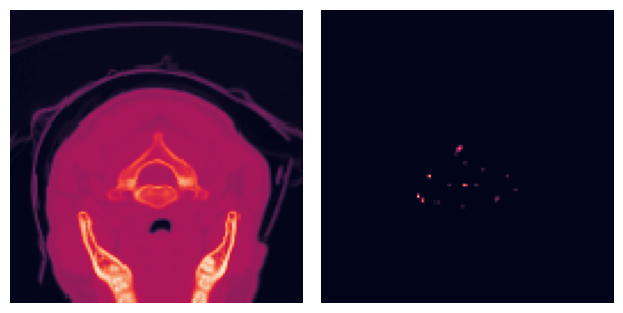

In [13]:
# Take the first processed batch and print the shape
image, label = first(train_loader)
print(image.shape, label.shape)

# Plot example image and label
fig, (ax1, ax2) = plt.subplots(1, 2)

s = 29
vertebrae = 1

ax1.imshow(image[1, 0, :, :, s])
ax1.axis('off')

ax2.imshow(label[1,vertebrae, :, :, s])
ax2.axis('off')

plt.tight_layout()  # Optional: improve spacing between plots
plt.show()

## Validation Transforms

In [14]:
# Define transforms for image
val_image_trans = Compose(
    [   # Load Data
        read_dicom_scan,
        # Data Preparation
        expand_dims, 
        Resize(spatial_size=config['spatial_size'], mode="area"), # Resize the volume to target spatial_size
        ScaleIntensity() # Scale between (0,1)
    ]
)

# Define transforms for label
val_label_trans = Compose(
    [   # Load data
        read_nifti_file,
        # Data Preparation
        expand_dims,
        Resize(spatial_size=config['spatial_size'], mode="area"),
        one_hot_encoding_multiclass_mask
    ]
)

# Define train dataset, dataloader
val_ds = ArrayDataset(df_val.image_path, val_image_trans, df_val.label_path, val_label_trans)

val_loader = DataLoader(val_ds, 
                        batch_size=config['batch_size'], 
                        shuffle=False,
                        num_workers=2
                       )

torch.Size([4, 1, 128, 128, 128]) torch.Size([4, 8, 128, 128, 128])


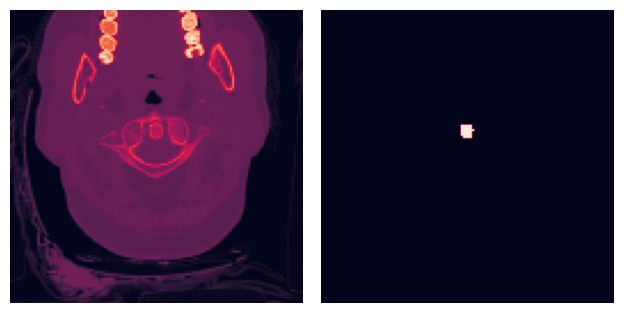

In [15]:
# Take the first processed batch and print the shape
image, label = first(val_loader)
print(image.shape, label.shape)

# Plot example image and label
fig, (ax1, ax2) = plt.subplots(1, 2)

s = 29
vertebrae = 2

ax1.imshow(image[1, 0, :, :, s])
ax1.axis('off')

ax2.imshow(label[1,vertebrae, :, :, s])
ax2.axis('off')

plt.tight_layout()  # Optional: improve spacing between plots
plt.show()

# Model, Optimizer and Scheduler
---

In this section we will define the model used for 3D segmentation, the optimization algorithm and the learning rate scheduler

- `Model`: has UNet architecture which is *state-of-the-art* for 3D segmentation of medical images. We exploit [MONAI](https://docs.monai.io/en/stable/networks.html#unet) library for its implementation.
- `Optimizer`: the optimization algorithm employed for training the 3D segmentation model is **AdamW**.
- `lr scheduler`: we chose the **CosineAnnealingLR** from **PyTorch**.
- `post_trans`: are transformations applied to model output, namely **softmax** function along the channels of the predicted mask and a **threshold**.

In [16]:
# Create Model with UNet architecture
model = UNet(spatial_dims=3, # (Height, Width, Depth)
             in_channels=1,  
             out_channels=8, # 8 binary mask 7 as the vertebrae(C1->C7) + background
             channels=config['channels'], 
             strides=config['strides'], 
             kernel_size=config['kernel_size'], 
             up_kernel_size=config['up_kernel_size'], 
             num_res_units=config['num_res_units'], 
             act=config['act'], 
             dropout=config['dropout'], 
             bias=config['bias']
            ).to(device)

# Define the transforms to apply to model prediction, Softmax because multiclass segmentation problem
post_trans = Compose([Activations(sigmoid=False, softmax=True, dim=0), AsDiscrete(threshold=0.5)])

# AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = config['lr'] )

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

# Use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_23/3489489263.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# Losses & Metrics
---

The loss function used during training is the weighted sum of **Dice Loss** and **BCE Loss** because combining these two losses yields the best result in terms of segmentation, pixel-wise accuracy, generalization and adversarial attacks as shown in [Robustness of different loss functions and their impact on networks learning capability](https://arxiv.org/abs/2110.08322).

The weights allows us to balance the effects of the two losses. The best combination after model selection is $\alpha=0.05$ and $\beta=0.95$

$$\alpha \cdot \text{BCE} + \beta \cdot \text{Dice loss}$$

Below a brief explanation of the two losses.

## Dice Loss

 **Dice Loss** is a popular loss function for image segmentation and **measures the overlap between the predicted segmentation and the ground truth**. 
The advantage of using dice loss is that it can very well **handle the class imbalance** in terms of pixel count for foreground and background. Class imbalances is a common scenario in medical images where the background vastly outnumbers the foreground as in the current case.
The dice loss formula is reported below.

$$ \text{Dice Loss} = 1 - \frac{2\sum_{i=1}^{n}p_i y_i}{\sum_{i=1}^{n}p_{i}^{2}+\sum_{i=1}^{n}y_{i}^{2}}$$

Where $y_{i}$ is the real pixel value and $p_{i}$ is the predicted pixel value.

We exploit MONAI implementation of Dice Loss, in what follows we will explain the chosen parameters setting:
- `softmax=True`. In **multi-class semantic segmentation problem** each voxel of the input volume can belong to at most one class. In the current problem we have 8 classes (background and C1, ..., C7 vertebrae). **Softmax activation** function is applied to the raw output of the segmentation model to ensure that the sum of the predicted probabilities over the 8 binary channels sum up to 1.
- `include_background=False`. We decide to exclude the first channel (background) from the loss to focus the attention of the model in the prediction of the C1, ..., C7 vertebrae.
- `squared_pred=False`. At the denominator we do NOT use the squared prediction of the real pixel value and predicted pixel value.
- `reduction='mean'` The reduction applied to the output, i.e. the mean over the sample in the processed batch.


## BCE - Binary Crossentropy

**BCE Loss** (Binary Crossentropy) is commonly used in binary classification problem where the target can only assumes value 0 or 1, this is the case of image segmentation if we consider the pixels of the binary encoded masks.

$$\text{BCE Loss} = - \frac{1}{N}\sum_{i=1}^{n}[y_i log(p_i) + (1-y_i)log(1-p_i)]$$

We exploit Pytorch implementation of BCE, in particular withLogitsLoss version because the output of the model is between $[-inf, +inf]$



In [17]:
# Define Dice Loss
dice_loss_function = DiceLoss(include_background=False,  # If False, channel index 0 (background) is excluded from the calculation
                              softmax=True,              # Softmax to raw prediction because multi-class segmentation problem
                              sigmoid=False, 
                              squared_pred=False,        # Use squared versions of targets and predictions in the denominator or not
                              reduction='mean'           # Reduction to apply to the output
                              )

# Define Binary CrossEntropy With Logits Loss, PyTorch implementation
bce_loss_function = nn.BCEWithLogitsLoss()

# Combine BCE and Dice losses
def bce_dice_loss_function(input, target, loss_weights=config['loss_weights']):
    bce_loss = loss_weights[0] * bce_loss_function(input, target)
    dice_loss = loss_weights[1] * dice_loss_function(input, target)
    total_loss = (bce_loss + dice_loss) / sum(loss_weights)
    return total_loss

# Define Dice Metric
metric = DiceMetric(include_background=False, reduction="mean")

# Training Loop
---

In [18]:
# Container to store train losses values per epoch
train_bce_dice_loss_values = []
train_dice_loss_values = []
train_bce_loss_values = []

# Container to store val loss values per epoch
val_bce_dice_loss_values = []
val_dice_loss_values = []
val_bce_loss_values = []

# Container to store val metric values per epoch
val_dice_metric_values = []

# Store best val metric
best_val_metric = -1

total_start = time.time()
# Iterate over the epochs
for epoch in range(1, config['epochs']+1):
    epoch_start = time.time()
    print("-" * 10)
    print(f"EPOCH {epoch}/{config['epochs']}")
    model.train() # Set the model in training mode
    batch_bce_dice_losses = 0
    batch_bce_losses = 0
    batch_dice_losses = 0
    batch_val_bce_dice_losses = 0
    batch_val_dice_losses = 0
    batch_val_bce_losses = 0
    # Iterate over the batches
    for step, batch_data in enumerate(train_loader):
        step_start = time.time()
        inputs, labels = batch_data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # Clear the old gradients before computing new ones
        # Enable automatic mixed precision (amp)
        with torch.cuda.amp.autocast():
            outputs = model(inputs) # Make predictions for current batch
            # Compute train losses
            bce_dice_loss = bce_dice_loss_function(outputs, labels)
            dice_loss = dice_loss_function(outputs, labels)
            bce_loss = bce_loss_function(outputs, labels)
        scaler.scale(bce_dice_loss).backward() # Compute the gradients
        scaler.step(optimizer) # Update model weights
        scaler.update()
        
        batch_bce_dice_losses += bce_dice_loss.item()
        batch_bce_losses += bce_loss.item()
        batch_dice_losses += dice_loss.item()
        
        # REPORT PER BATCH 
        print(
            f"batch: {step}/{len(train_ds) // train_loader.batch_size}"
            f", bce_dice: {bce_dice_loss.item():.4f}"
            f", dice_loss: {dice_loss.item():.4f}"
            f", bce_loss: {bce_loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
        
    # Compute average train loss per epoch
    avg_bce_dice_loss = batch_bce_dice_losses / (step + 1)
    avg_dice_loss = batch_dice_losses / (step + 1)
    avg_bce_loss = batch_bce_losses / (step + 1)
    
    # EVALUATE MODEL ON VALIDATION SET
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient computation and reduce memory consumption.
        for step, val_data in enumerate(val_loader):
            val_inputs, val_labels = val_data
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            # Compute val losses
            val_bce_dice_loss = bce_dice_loss_function(val_outputs, val_labels)
            batch_val_bce_dice_losses += val_bce_dice_loss.item()
            val_dice_loss = dice_loss_function(val_outputs, val_labels)
            batch_val_dice_losses += val_dice_loss.item()
            val_bce_loss = bce_loss_function(val_outputs, val_labels)
            batch_val_bce_losses += val_bce_loss.item()
            # Compute val metric
            val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
            metric(y_pred=val_outputs, y=val_labels)
        
        # Compute average val loss per epoch
        avg_val_bce_dice_loss = batch_val_bce_dice_losses / (step + 1)
        avg_val_dice_loss = batch_val_dice_losses / (step + 1)
        avg_val_bce_loss = batch_val_bce_losses / (step + 1)
        avg_val_dice_metric = metric.aggregate().item()
    
    # REPORT PER EPOCH
    print(f'TRAIN LOSSES, bce_dice: {avg_bce_dice_loss:.4f}, bce:{avg_bce_loss:.4f}, dice:{avg_dice_loss:.4f}')
    print(f'VALID LOSSES, bce_dice: {avg_val_bce_dice_loss:.4f}, bce:{avg_val_bce_loss:.4f}, dice:{avg_val_dice_loss:.4f}')
    print(f'VALID METRIC, dice: {avg_val_dice_metric:.4f}')
    
    # Store train and val losses & metrics per epoch    
    train_bce_dice_loss_values.append(avg_bce_dice_loss) 
    train_dice_loss_values.append(avg_dice_loss)
    train_bce_loss_values.append(avg_bce_loss)
    val_bce_dice_loss_values.append(avg_val_bce_dice_loss)
    val_dice_loss_values.append(avg_val_dice_loss)
    val_bce_loss_values.append(avg_val_bce_loss)
    val_dice_metric_values.append(avg_val_dice_metric)
    
    metric.reset()
    
    # Track best performance, and save the best model's state
    if avg_val_dice_metric > best_val_metric:
        best_val_metric = avg_val_dice_metric
        best_model = {'epoch': epoch,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                      'loss': avg_bce_dice_loss
                     }
            
    print(f"time consuming of epoch {epoch} is: {(time.time() - epoch_start):.4f}")
    
    # Save last model's state
    if epoch == config['epochs']:
        last_model = {'epoch': epoch,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                      'loss': avg_bce_dice_loss
                      }

total_time = time.time() - total_start
    
# Save Train and Val Loss 
with open(OUTPUT_FILE, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['train_bce_dice_loss', 'train_dice_loss', 'train_bce_loss', 
                       'val_bce_dice_loss', 'val_dice_loss', 'val_bce_loss', 
                       'val_dice_metric'])
    csvwriter.writerows(zip(train_bce_dice_loss_values, train_dice_loss_values, train_bce_loss_values,
                           val_bce_dice_loss_values, val_dice_loss_values, val_bce_loss_values, 
                           val_dice_metric_values))

# Save Best Model's State
best_model_path = os.path.join(OUTPUT_DIR, f"{config['ID']}_best_model")
torch.save(best_model, best_model_path)

# Save Last Model's State
last_model_path = os.path.join(OUTPUT_DIR, f"{config['ID']}_last_model")
torch.save(last_model, last_model_path)

----------
EPOCH 1/80


/tmp/ipykernel_23/1724095609.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


batch: 0/17, bce_dice: 0.9906, dice_loss: 0.9966, bce_loss: 0.8771, step time: 6.1765
batch: 1/17, bce_dice: 0.9908, dice_loss: 0.9973, bce_loss: 0.8672, step time: 0.3153
batch: 2/17, bce_dice: 0.9909, dice_loss: 0.9977, bce_loss: 0.8616, step time: 0.4020
batch: 3/17, bce_dice: 0.9891, dice_loss: 0.9962, bce_loss: 0.8550, step time: 0.3087
batch: 4/17, bce_dice: 0.9887, dice_loss: 0.9961, bce_loss: 0.8476, step time: 0.3632
batch: 5/17, bce_dice: 0.9890, dice_loss: 0.9970, bce_loss: 0.8370, step time: 0.4007
batch: 6/17, bce_dice: 0.9885, dice_loss: 0.9972, bce_loss: 0.8247, step time: 0.3604
batch: 7/17, bce_dice: 0.9881, dice_loss: 0.9969, bce_loss: 0.8200, step time: 0.3665
batch: 8/17, bce_dice: 0.9869, dice_loss: 0.9960, bce_loss: 0.8149, step time: 0.3991
batch: 9/17, bce_dice: 0.9850, dice_loss: 0.9944, bce_loss: 0.8068, step time: 0.3975
batch: 10/17, bce_dice: 0.9859, dice_loss: 0.9957, bce_loss: 0.8008, step time: 0.3610
batch: 11/17, bce_dice: 0.9861, dice_loss: 0.9965, bc

# Plot Training & Validation Losses
---

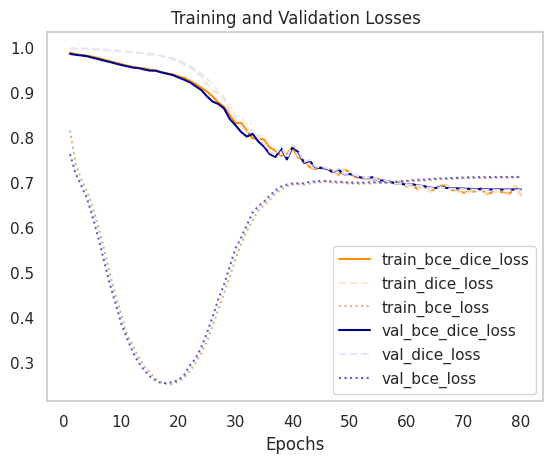

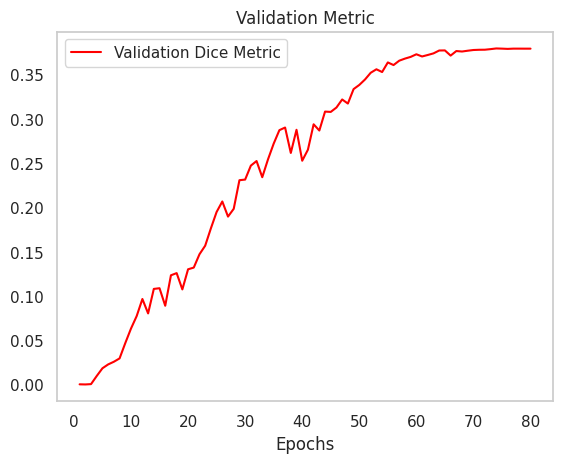

In [19]:
# Load txt file
path = f"/kaggle/working/{config['ID']}_train_val_losses.csv"
train_val_losses = pd.read_csv(path)

# Plot and Save Train Val Losses as png in output dir
training_plot(train_val_losses, OUTPUT_DIR, config)
validation_metric_plot(train_val_losses, OUTPUT_DIR, config)